<a href="https://colab.research.google.com/github/cyuancheng/fastai_v3/blob/master/Skin_Cancer_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# importing all libraries
import os
import shutil
import pandas as pd

Scrape Google Images for Data

google_images_download

In [5]:
# Downloading google image scraper & chromedriver (allows us to download more than 100 images)
!pip install google_images_download
!sudo apt-get install chromium-chromedriver

    100% |████████████████████████████████| 911kB 13.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 8 not upgraded.
Need to get 64.3 MB of archives.
After this operation, 238 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 71.0.3578.98-0ubuntu0.18.04.1 [1,106 kB]
Get:2 http://archive.ubuntu

In [5]:
# downloading images
!googleimagesdownload --keywords "Skin Cancer,Benign Mole" --limit 120 --format jpg --type photo --size medium --chromedriver /usr/lib/chromium-browser/chromedriver


Item no.: 1 --> Item name = Skin Cancer
Evaluating...
Getting you a lot of images. This may take a few moments...
Reached end of Page.
Starting Download...
Completed Image ====> 1. dermnet_photo_of_squamous_cell_carcinoma_lesion.jpg
Completed Image ====> 2. 1497971048492.jpg
Completed Image ====> 3. princ_photo_of_skin_cancer_screening.jpg
Completed Image ====> 4. collage_of_basal_cell_carcinoma.jpg
Completed Image ====> 5. simple-ways-to-spot-skin-cancer-slide-01.jpg
Completed Image ====> 6. image.img.full.high.jpg
Completed Image ====> 7. 1497970919728.jpg
Completed Image ====> 8. g19ioji_psoriasis-_625x300_27_july_18.jpg
Completed Image ====> 9. skin-cancer.jpg
Completed Image ====> 10. 8-ways-your-body-changes-after-one-sunburn-4.jpg
Completed Image ====> 11. skin-cancer-faqs-e1509655886517.jpg
Completed Image ====> 12. fe7e118e644253563b60ea93086ec51f_xl.jpg
Completed Image ====> 13. hqdefault.jpg
Completed Image ====> 14. dermnet_photo_of_actinic_keratosis.jpg
Completed Image ==

Data clean

In [0]:
# Paths for both benign images, cancer images

# Benign folder
PATH_BENIGN = "./downloads/Benign Mole"

# Cancer folder
PATH_CANCER = "./downloads/Skin Cancer"

In [10]:
# The following line will list the directory
os.listdir(PATH_CANCER)[:5]

['108. ds00190_-ds00924_im00892_r7_squamouscellthu_jpg',
 '33. 1497970620585.jpg',
 '112. skin-cancer-symptoms-rm-722x406.jpg',
 '117. 800-lg.jpg',
 '114. skin-cancer-s1.jpg']

In [0]:
# function to remove images that aren't jpgs
def clean_dir(PATH):
    for file in os.listdir(PATH):
        if file.endswith('.jpg'):
            pass
        else:
            os.remove(f'{PATH}/{file}')

# function to trim the folder down to 100 images
def shape_dir(PATH):
    count = 0
    for file in os.listdir(PATH):
        count += 1
        if count > 100:
            os.remove(f'{PATH}/{file}')
    print('finished')

In [12]:
# calling functions
clean_dir(PATH_BENIGN)
clean_dir(PATH_CANCER)

shape_dir(PATH_BENIGN)
shape_dir(PATH_CANCER)

finished
finished


In [13]:
os.listdir(PATH_CANCER)[:5]

['33. 1497970620585.jpg',
 '112. skin-cancer-symptoms-rm-722x406.jpg',
 '117. 800-lg.jpg',
 '114. skin-cancer-s1.jpg',
 '64. sensus-healthcare-pmk-branded-photo-5.jpg']

rename images

In [0]:
os.getcwd()

new_name = ['benign', 'cancer']

def parse_images(path, new_name):
    for i, filename in enumerate(os.listdir(path)):
        os.rename(path + "/" + filename, path + "/" + new_name + "." + str(i) + ".jpg")

parse_images(PATH_BENIGN, new_name[0])
parse_images(PATH_CANCER, new_name[1])

In [15]:
# Let's check if the name's have been changed
print(os.listdir(PATH_BENIGN)[:5])
print(os.listdir(PATH_CANCER)[:5])

['benign.49.jpg', 'benign.42.jpg', 'benign.72.jpg', 'benign.76.jpg', 'benign.82.jpg']
['cancer.36.jpg', 'cancer.30.jpg', 'cancer.12.jpg', 'cancer.8.jpg', 'cancer.50.jpg']


In [18]:
series = pd.Series(os.listdir(PATH_CANCER))
series.count()

100

In [17]:
series.head()

0    cancer.36.jpg
1    cancer.30.jpg
2    cancer.12.jpg
3     cancer.8.jpg
4    cancer.50.jpg
dtype: object

In [0]:
# run this following script to make the directory structure
%mkdir cancerdata
%mkdir cancerdata/train | mkdir cancerdata/valid
%mkdir cancerdata/train/benign | mkdir cancerdata/train/cancer
%mkdir cancerdata/valid/benign | mkdir cancerdata/valid/cancer

In [0]:
# Grabbing file paths
source = ['./downloads/Benign Mole', './downloads/Skin Cancer']
train_dest = ['./cancerdata/train/benign', './cancerdata/train/cancer']
valid_dest = ['./cancerdata/valid/benign', './cancerdata/valid/cancer']

In [0]:
# Creating our function to split into Train, Valid sets
def split_images(source, train_dest, valid_dest, f_name):
    files = os.listdir(source)
    iter_t = 80
    iter_v =20
    for i in range(iter_t):
        shutil.move(source + '/' + f_name + '.' + str(i) + '.jpg', train_dest)
    for i in range(iter_v):
        shutil.move(source + '/' + f_name + '.' + str(i + 80) + '.jpg', valid_dest)

In [0]:
# Calling the functions

# Benign Moles
split_images(source[0], train_dest[0], valid_dest[0], f_name='benign')

# Skin Cancer
split_images(source[1], train_dest[1], valid_dest[1], f_name='cancer')

In [0]:
# Transforming our data in pandas series
series_train_benign = pd.Series(os.listdir(train_dest[0]))
series_train_cancer = pd.Series(os.listdir(train_dest[1]))
series_valid_benign = pd.Series(os.listdir(valid_dest[0]))
series_valid_cancer = pd.Series(os.listdir(valid_dest[1]))

In [24]:
# Checking our data
print(f'train/benign set = {series_train_benign.nunique()}')
print(f'train/cancer set = {series_train_cancer.nunique()}')
print(f'valid/benign set = {series_valid_benign.nunique()}')
print(f'valid/cancer set = {series_valid_cancer.nunique()}')

train/benign set = 80
train/cancer set = 80
valid/benign set = 20
valid/cancer set = 20


In [25]:
# Listing path of data
PATH = './cancerdata'

os.listdir(PATH) # checks the path

['train', 'valid']

In [0]:
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
#                                  ).normalize(imagenet_stats)


data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(),
                                   size=224).normalize(imagenet_stats)

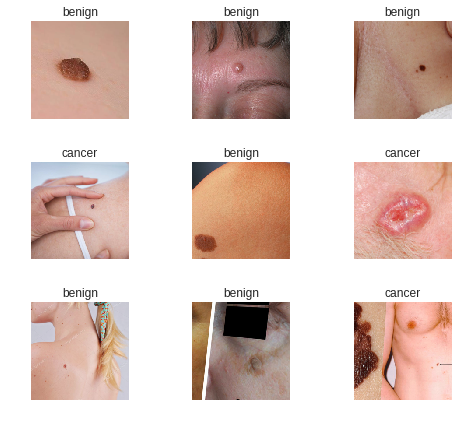

In [30]:
data.show_batch(rows=3, figsize=(7,6))

In [28]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 28286484.77it/s]


In [31]:
print(data.classes)
len(data.classes),data.c

['benign', 'cancer']


(2, 2)

In [1]:
learn.fit_one_cycle(4)

NameError: ignored